# Impact of Order Latency

This example illustrates the impact of order latency on the performance of the strategy.

<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord


@njit
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]

@njit
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept

@njit
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2

@njit
def gridtrading_glft_mm(hbt, order_qty, recorder):
    asset_no = 0
    tick_size = hbt.depth(asset_no).tick_size
    
    arrival_depth = np.full(10_000_000, np.nan, np.float64)
    mid_price_chg = np.full(10_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan

    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + 0.5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = grid_num * order_qty
    adj2 = 1 / max_position
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000_000) == 0:
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for last_trade in hbt.last_trades(asset_no):
                trade_price_tick = last_trade.px / tick_size
                
                if last_trade.ev & BUY_EVENT == BUY_EVENT:
                    depth = max(trade_price_tick - mid_price_tick, depth)
                else:
                    depth = max(mid_price_tick - trade_price_tick, depth)
            arrival_depth[t] = depth
        
        hbt.clear_last_trades(asset_no)
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid_tick = depth.best_bid_tick
        best_ask_tick = depth.best_ask_tick
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (best_bid_tick + best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)

        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread_tick = (c1 + delta / 2 * c2 * volatility) * adj1
        skew = c2 * volatility * adj2
        
        reservation_price_tick = mid_price_tick - skew * position

        bid_price_tick = min(np.round(reservation_price_tick - half_spread_tick), best_bid_tick)
        ask_price_tick = max(np.round(reservation_price_tick + half_spread_tick), best_ask_tick)
        
        bid_price = bid_price_tick * tick_size
        ask_price = ask_price_tick * tick_size

        grid_interval = max(np.round(half_spread_tick) * tick_size, tick_size)

        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position < max_position and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position > -max_position and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        #--------------------------------------------------------
        # Records variables and stats for analysis.
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        recorder.record(hbt)

## Order Latency from Feed Latency

Please see [the tutorial](https://hftbacktest.readthedocs.io/en/latest/tutorials/Order%20Latency%20Data.html) on generating artificial order latency data from feed latency.

In [2]:
asset = (
    BacktestAsset()
        .data([
            'data/ethusdt_20230401.npz',
            'data/ethusdt_20230402.npz',
            'data/ethusdt_20230403.npz',
            'data/ethusdt_20230404.npz',
            'data/ethusdt_20230405.npz'
        ])
        .initial_snapshot('data/ethusdt_20230331_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency([
            'latency/feed_latency_20230401.npz',
            'latency/feed_latency_20230402.npz',
            'latency/feed_latency_20230403.npz',
            'latency/feed_latency_20230404.npz',
            'latency/feed_latency_20230405.npz'
        ])
        .power_prob_queue_model(2.0) 
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)    
        .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

gridtrading_glft_mm(hbt, 1, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=25_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00,2023-04-05 23:59:50,-0.197608,-0.224204,-0.001021,0.060794,4459.903239,328.415763,-0.016794,-6.2176e-7,75431.07


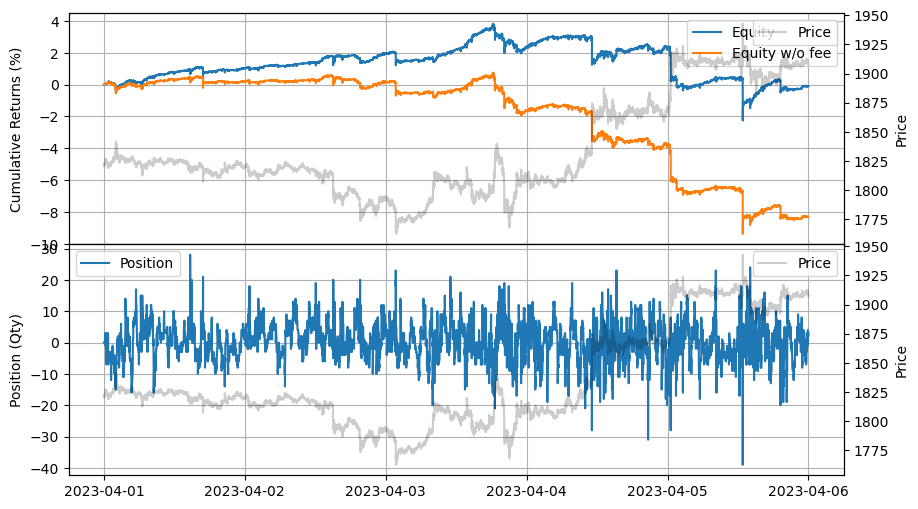

In [3]:
stats.plot()

## Live Order Latency

In [4]:
latency_data = np.concatenate(
    [np.load('latency/live_order_latency_{}.npz'.format(date))['data'] for date in range(20230401, 20230406)]
)
    
asset = (
    BacktestAsset()
        .data([
            'data/ethusdt_20230401.npz',
            'data/ethusdt_20230402.npz',
            'data/ethusdt_20230403.npz',
            'data/ethusdt_20230404.npz',
            'data/ethusdt_20230405.npz'
        ])
        .initial_snapshot('data/ethusdt_20230331_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(2.0) 
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)    
        .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

gridtrading_glft_mm(hbt, 1, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=25_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00,2023-04-05 23:59:50,1.536293,1.741565,0.007814,0.051916,4563.105627,336.150295,0.150518,0.000005,67694.55


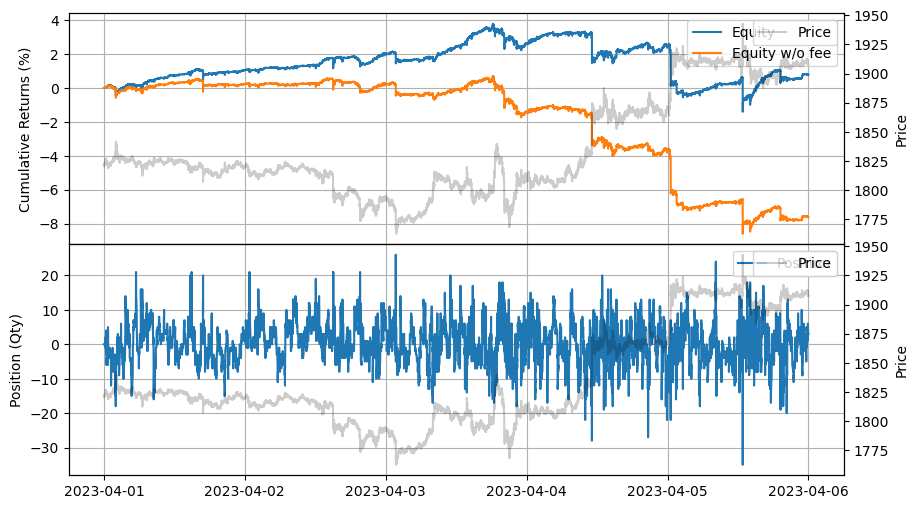

In [5]:
stats.plot()

## Order Latency from Amplified Feed Latency

Order entry latency is 4 times the feed latency and order response latency is 3 times the feed latency.

In [6]:
asset = (
    BacktestAsset()
        .data([
            'data/ethusdt_20230401.npz',
            'data/ethusdt_20230402.npz',
            'data/ethusdt_20230403.npz',
            'data/ethusdt_20230404.npz',
            'data/ethusdt_20230405.npz'
        ])
        .initial_snapshot('data/ethusdt_20221002_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency([
            'latency/amp_feed_latency_20230401.npz',
            'latency/amp_feed_latency_20230402.npz',
            'latency/amp_feed_latency_20230403.npz',
            'latency/amp_feed_latency_20230404.npz',
            'latency/amp_feed_latency_20230405.npz'
        ])
        .power_prob_queue_model(2.0) 
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.01)
        .lot_size(0.001)
        .roi_lb(0.0)    
        .roi_ub(3000.0)
        .last_trades_capacity(10000)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 5_000_000)

gridtrading_glft_mm(hbt, 1, recorder.recorder)

hbt.close()

stats = LinearAssetRecord(recorder.get(0)).stats(book_size=25_000)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2023-04-01 00:00:00,2023-04-05 23:59:50,-0.376802,-0.430111,-0.002163,0.053785,4366.301072,321.501683,-0.040224,-0.000001,75711.93


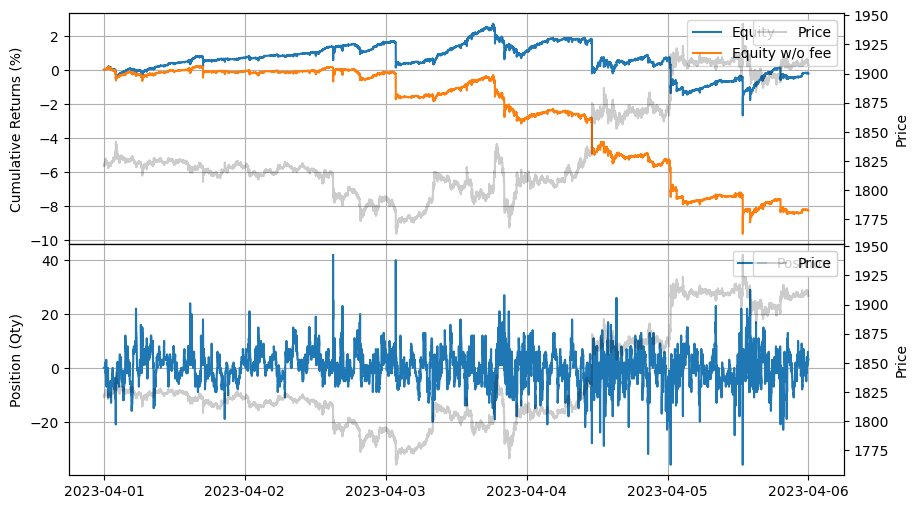

In [7]:
stats.plot()